## **Stock Market Price Using LSTM**

In this notebook, we are predicting the stock market price using lstm on Microsoft and Apple data-set. The csv file is uploaded in the colab folder. 


### **Importing Libraries below**

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model

### **Reading the data-set from CSV file**
Reading the data by parsing date means making data column as index as it is timeseries.  


In [2]:
# Microsoft Data-set
df_final = pd.read_csv("/kaggle/input/msftcsv/MSFT.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True) # reading the data
# Apple Data-set
#df_final = pd.read_csv("/kaggle/input/aaplcsv/AAPL.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True) # reading the data

In [3]:
df_final.head() # to check how our data looks like

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.605903,0.616319,0.598090,0.616319,0.447268,53033600
1990-01-03,0.621528,0.626736,0.614583,0.619792,0.449788,113772800
1990-01-04,0.619792,0.638889,0.616319,0.638021,0.463017,125740800
1990-01-05,0.635417,0.638889,0.621528,0.622396,0.451678,69564800
1990-01-08,0.621528,0.631944,0.614583,0.631944,0.458607,58982400


In [4]:
df_final.shape # to check the size of our columns and rows

(7334, 6)

In [5]:
df_final.describe() # calculating mathematical expressions

,Open,High,Low,Close,Adj Close,Volume
count,7334.000000,7334.000000,7334.000000,7334.000000,7334.000000,7.334000e+03
mean,28.578362,28.891892,28.261203,28.582426,24.008891,6.022760e+07
std,22.279033,22.476021,22.054379,22.275692,21.941225,3.400345e+07
min,0.591146,0.604167,0.583333,0.598090,0.434039,3.705600e+06
25%,12.457031,12.595703,12.261719,12.488281,9.062849,3.821840e+07
50%,26.980000,27.235000,26.730000,26.990000,20.431164,5.429885e+07
75%,34.716562,35.099998,34.250000,34.687500,26.993589,7.367888e+07
max,115.419998,116.180000,114.930000,115.610001,115.112709,7.645040e+08


In [6]:
df_final.isnull().values.any() # to check if there is any null or missing values in our data

False

<AxesSubplot:xlabel='Date'>

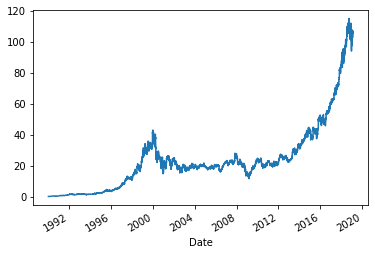

In [7]:
df_final['Adj Close'].plot() # let's have a look how our close columns looks - we will be making prediction on this target 

In [8]:
X=df_final.drop(['Adj Close'],axis=1) # dropping the target column from the data
X=X.drop(['Close'],axis=1)

### **Correlation Analysis**

<AxesSubplot:title={'center':'Correlation with Adj Close'}>

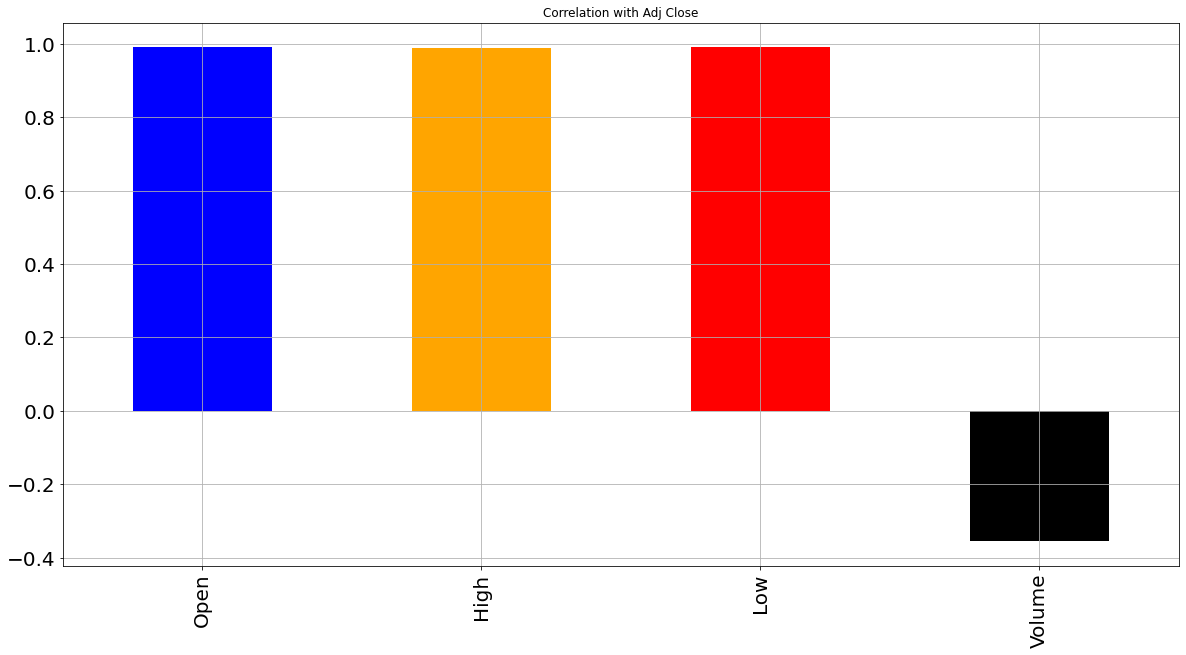

In [9]:
c = ['blue', 'orange', 'red', 'black', 'orange']
X.corrwith(df_final['Adj Close']).plot.bar(
        figsize = (20, 10), title = "Correlation with Adj Close", fontsize = 20,
        rot = 90, grid = True, color = c)

In [10]:
test = df_final
# Target column
target_adj_close = pd.DataFrame(test['Adj Close'])
display(test.head()) # checking the test data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.605903,0.616319,0.598090,0.616319,0.447268,53033600
1990-01-03,0.621528,0.626736,0.614583,0.619792,0.449788,113772800
1990-01-04,0.619792,0.638889,0.616319,0.638021,0.463017,125740800
1990-01-05,0.635417,0.638889,0.621528,0.622396,0.451678,69564800
1990-01-08,0.621528,0.631944,0.614583,0.631944,0.458607,58982400


In [11]:
# selecting Feature Columns
feature_columns = ['Open', 'High', 'Low', 'Volume']

### **Normalizing the data**

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume
Date,,,,
1990-01-02,0.000129,0.000105,0.000129,0.064837
1990-01-03,0.000265,0.000195,0.000273,0.144673
1990-01-04,0.000249,0.000300,0.000288,0.160404
1990-01-05,0.000386,0.000300,0.000334,0.086566
1990-01-08,0.000265,0.000240,0.000273,0.072656


In [13]:
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)

# Shift target array because we want to predict the n + 1 day value


target_adj_close = target_adj_close.shift(-1)
validation_y = target_adj_close[-90:-1]
target_adj_close = target_adj_close[:-90]

# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)
display(target_adj_close.tail())

,Open,High,Low,Volume
Date,,,,
1990-01-02,0.000129,0.000105,0.000129,0.064837
1990-01-03,0.000265,0.000195,0.000273,0.144673
1990-01-04,0.000249,0.000300,0.000288,0.160404
1990-01-05,0.000386,0.000300,0.000334,0.086566
1990-01-08,0.000265,0.000240,0.000273,0.072656


Shape of features :  (7334, 4)
Shape of target :  (7334, 1)


,Open,High,Low,Volume
Date,,,,
2019-02-01,0.898632,0.895480,0.889984,0.041838
2019-02-04,0.890707,0.910189,0.893657,0.036290
2019-02-05,0.918487,0.922908,0.921554,0.031046
2019-02-06,0.926673,0.920572,0.917794,0.022219
2019-02-07,0.910911,0.908372,0.906950,0.034247


,Adj Close
Date,
2019-02-01,105.739998
2019-02-04,107.220001
2019-02-05,106.029999
2019-02-06,105.269997
2019-02-07,105.669998



 -----After process------ 

Shape of features :  (7244, 4)
Shape of target :  (7244, 1)


,Adj Close
Date,
2018-09-24,113.957695
2018-09-25,113.489723
2018-09-26,113.917870
2018-09-27,113.878044
2018-09-28,115.112709


### **Train test split using Timeseriessplit**

In [14]:
# train test Split using Timeseriessplit
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()


In [15]:
X_train.shape

(6586, 4)

In [16]:
X_test.shape

(658, 4)

In [17]:
y_train.shape

(6586,)

In [18]:
y_test.shape

(658,)

In [19]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

### **Benchmark Model**

**Decision Tree Regressor**

RMSE:  64.22105109555618
R2 score:  -304.3934023786509


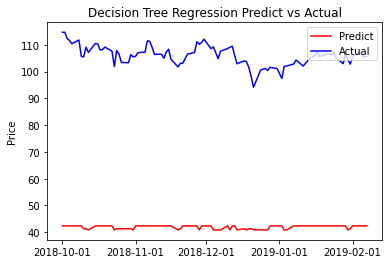

In [20]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=0)

benchmark_dt=dt.fit(X_train, y_train)

validate_result(benchmark_dt, 'Decision Tree Regression')

## **LSTM Implementation**

### **Data-Processing for LSTM**

In [21]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

### **LSTM Model**

In [22]:
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=300, batch_size=1, verbose=1, shuffle=False, callbacks=[early_stop])

2022-11-25 18:15:12.664365: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-11-25 18:15:12.929303: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/300
6586/6586 [==============================] - 12s 2ms/step - loss: 0.7490
Epoch 2/300
6586/6586 [==============================] - 10s 2ms/step - loss: 3.9047
Epoch 3/300
6586/6586 [==============================] - 11s 2ms/step - loss: 0.5854
Epoch 4/300
6586/6586 [==============================] - 10s 2ms/step - loss: 0.3488
Epoch 5/300
6586/6586 [==============================] - 10s 2ms/step - loss: 0.3220
Epoch 6/300
6586/6586 [==============================] - 10s 2ms/step - loss: 0.3204
Epoch 7/300
6586/6586 [==============================] - 10s 2ms/step - loss: 0.3203
Epoch 8/300
6586/6586 [==============================] - 10s 2ms/step - loss: 0.3193
Epoch 9/300
6586/6586 [==============================] - 10s 2ms/step - loss: 0.3180
Epoch 10/300
6586/6586 [==============================] - 11s 2ms/step - loss: 0.3167
Epoch 11/300
6586/6586 [==============================] - 10s 2ms/step - loss: 0.3156
Epoch 12/300
6586/6586 [==============================] - 10s 2

### **Evaluating the Model**

In [23]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)

The R2 score on the Train set is:	0.766
The R2 score on the Test set is:	0.858


### **Predictions using LSTM**

In [24]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

658/658 [==============================] - 1s 1ms/step - loss: 51.0389


In [25]:
print('LSTM: %f'%score_lstm)

LSTM: 51.038948


In [26]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

### **LSTM Prediction Visualization**

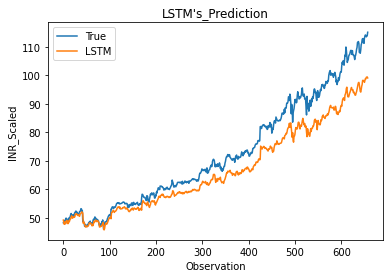

In [27]:
# A plot for the predicted and actual values should provide a more clear understanding.
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

### **Additional Implementation for training LSTM on same DataSet**

In [28]:
import math
import keras
close_prices = df_final['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [29]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [30]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 100)           40800     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Training model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
5808/5808 [==============================] - 251s 43ms/step - loss: 1.7272e-04
Epoch 2/3
5808/5808 [==============================] - 254s 44ms/step - loss: 8.3738e-05
Epoch 3/3
5808/5808 [==============================] - 255s 44ms/step - loss: 7.2780e-05


### **Calculating RMS**

In [32]:
# Calculating RMSE
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse 

1.4131684553405015

### **A Complete Visualization with LSTM**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


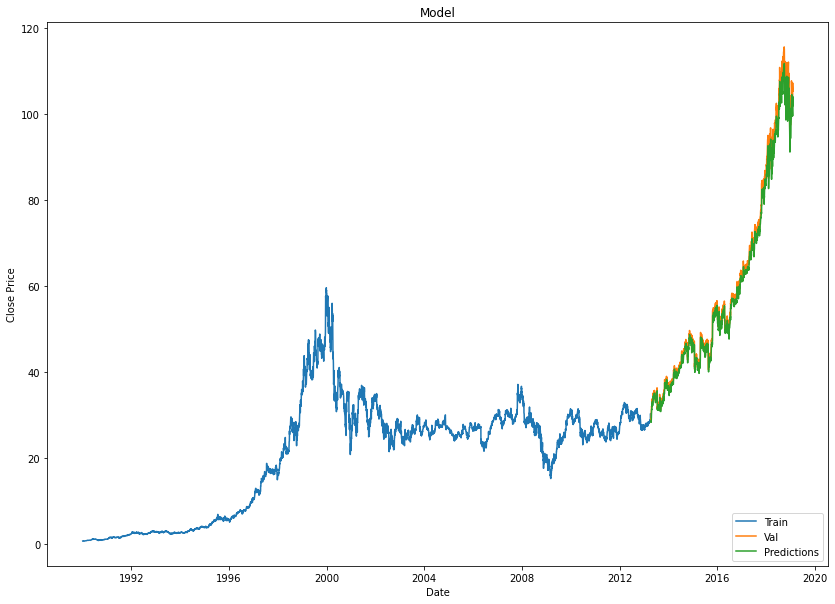

In [33]:
# Plotting complete visualization including training and testing
data = df_final.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(14,10))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

### **Converting Prediction data into CSV**
In this step I have made the prediction of test data and will convert the dataframe to csv so that we can see the price difference between actual and predicted price.

In [34]:
# saving predicted data into excel file
col1 = pd.DataFrame(y_test, columns=['True'])
col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])
col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_excel('PredictionResultsUsingLSTM.xlsx')

## **Comparison based on Datasets**

Lets apply the algorithm on Apple dataset and see the results by just uncommenting the apple data-set line.

### **Conclusion**
Because there are so many variables that might influence stock prices, it is hard to develop a model that can accurately predict the price by 99% of the time. We cannot therefore expect a perfect model, but the general trend of the anticipated price is consistent with the observed data, allowing the trader to use an indication and make his or her own trading decisions.

By adding more epochs, experimenting with various activation functions, or even altering the model's structure, we can further increase the model's accuracy.